In [57]:
import numpy as np
import matplotlib.pyplot as plt
from abtem import *
from abtem.utils import GaussianDistribution
from ase.io import read
from ase.build import surface, bulk
from tqdm.auto import tqdm
from ase.build import graphene

from tqdm.auto import tqdm
from abtem.measure import stack_measurements
from abtem.structures import orthogonalize_cell
from abtem.measure import center_of_mass

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

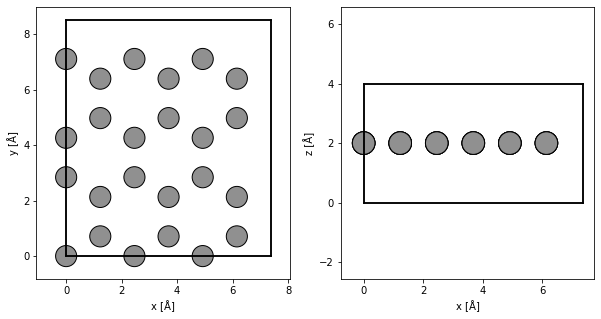

In [9]:
atoms = graphene()
atoms = orthogonalize_cell(atoms)
atoms *= (3,2,1)

atoms.center(vacuum=2, axis=2)
#atoms.center()

fig,(ax1,ax2)=plt.subplots(1, 2, figsize=(10,5))
show_atoms(atoms, ax=ax1)
show_atoms(atoms, ax=ax2, plane='xz');

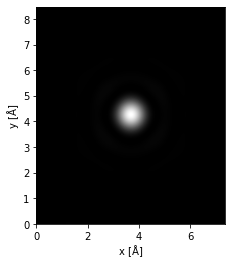

In [10]:
energy = 60e3

probe = SMatrix(energy=energy, semiangle_cutoff=30, device='cpu')
potential = Potential(atoms, #FrozenPhonons(atoms, sigmas=.06, num_configs=32), 
                      sampling=.04, 
                      projection='infinite',
                      parametrization='kirkland')
probe.grid.match(potential)

probe.build().collapse().show();

In [90]:
scan = GridScan((0, 0), (potential.extent[0] / 3, potential.extent[1] / 2), sampling = 
                probe.ctf.nyquist_sampling * .5)
detector = PixelatedDetector()

In [91]:
measurement = probe.scan(scan, detector, potential, pbar=False)
measurement.calibration_limits

[(0, 2.46),
 (0, 4.260844986619438),
 (-283.5238446531978, 283.5238446531978),
 (-279.8000785737092, 285.5102842588869)]

In [92]:
energy_spread = 0.35
Cc = 1.2e7
focal_spread = energy_spread / energy * Cc / 2.355

S = probe.multislice(potential, pbar=False)
S = S.downsample()

distribution = GaussianDistribution(0, 70, 51)
#measurement_temporal = detector.allocate_measurement(S, scan)

measurements = []
for defocus in tqdm(distribution.samples, desc='Defocus'):
    S.ctf.defocus = defocus
    measurements.append(S.scan(scan, detector, pbar=False)) 

Defocus:   0%|          | 0/51 [00:00<?, ?it/s]

In [44]:
focal_spread

29.723991507431

In [94]:
samples = distribution.samples

focal_spread = 50

values = np.exp(- samples ** 2 / (2 * focal_spread ** 2))
values /= values.sum()

array = np.stack([measurement.array for measurement in measurements])

measurement = Measurement((array * values[(slice(None),) + (None,)*4]).sum(0), calibrations=measurements[0].calibrations)

com = center_of_mass(measurement, return_magnitude=True)

#com

#plt.imshow(com.array)
#plt.colorbar()

#measurement


#distribution = GaussianDistribution(0, 10, 51)
#plt.plot(distribution.samples, values)

In [86]:
measurements[0].calibration_limits

[(1.23, 3.69),
 (0.0, 4.260844986619438),
 (-283.5238446531977, 283.5238446531977),
 (-279.8000785737092, 285.5102842588869)]

In [84]:
com.calibration_limits

[(1.23, 3.69), (0.0, 4.260844986619438)]

In [105]:
#measurements[0].show()
from abtem.visualize.interactive.canvas import Canvas
from abtem.visualize.interactive.artists import MeasurementArtist2d

import ipywidgets as widgets
from traitlets import link

canvas1 = Canvas()
canvas2 = Canvas()

image_artist1 = MeasurementArtist2d()
image_artist2 = MeasurementArtist2d()
canvas1.artists = {'image_artist': image_artist1}
canvas2.artists = {'image_artist': image_artist2}

energy_spread_slider = widgets.FloatSlider(description='Energy spread', min=1, max=100, value=1, step=1, continuous_update=False)
source_size_slider = widgets.FloatSlider(description='Source size', min=1, max=3, value=1, step=1, continuous_update=False)

autoadjust_button = widgets.ToggleButton(description='Autoadjust colorscale', value=True)

link((autoadjust_button, 'value'), (image_artist1.image_artist, 'autoadjust_colorscale'))

def update_image(*args):
    values = np.exp(- samples ** 2 / (2 * energy_spread_slider.value ** 2))
    values /= values.sum()
    measurement = Measurement((array * values[(slice(None),) + (None,)*4]).sum(0), calibrations=measurements[0].calibrations)
    com = center_of_mass(measurement, return_magnitude=True)
    image_artist1.measurement = com.interpolate(.1).tile((3,2))
    
    #canvas1._enforce_scale_lock()

energy_spread_slider.observe(update_image, 'value')
update_image()
canvas1.adjust_limits_to_artists()

widgets.HBox([canvas1.widget, canvas2.widget, widgets.VBox([autoadjust_button, energy_spread_slider])])


#com = center_of_mass(measurement, return_magnitude=True)

In [83]:
image_artist1.image_artist.extent

[(1.23, 13.530000000000001), (0.0, 12.782534959858316)]

In [80]:
image_artist1.limits

[(1.2054, 13.505400000000002), (-0.024772354573368828, 12.757762605284947)]

In [77]:
canvas1.x_limits

[1.2054, 13.505400000000002]

(<AxesSubplot:title={'center':'Slice (0, 0, 0) of (51, 13, 22, 86, 99) measurement'}, xlabel='alpha_x [mrad]', ylabel='alpha_y [mrad]'>,
 <matplotlib.image.AxesImage at 0x1fc820a6a30>)

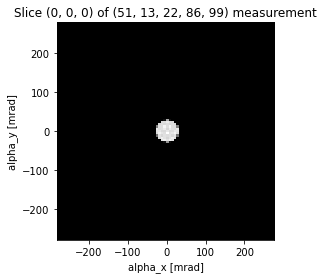

In [42]:
#measurement..show()

In [26]:
measurement_spatial = measurement.gaussian_filter((.75 / 2.355,) * 2 + (0.,) * 2)

measurement_temporal_spatial = measurement_temporal.gaussian_filter((.75 / 2.355,) * 2 + (0.,) * 2)

In [27]:
com = center_of_mass(measurement, return_magnitude=True)
com_temporal = center_of_mass(measurement_temporal, return_magnitude=True)
com_spatial = center_of_mass(measurement_spatial, return_magnitude=True)
com_temporal_spatial = center_of_mass(measurement_temporal_spatial, return_magnitude=True)

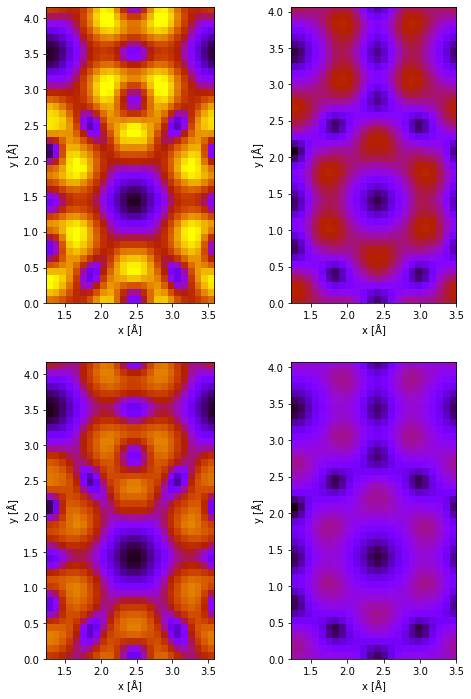

In [29]:
cmap = 'gnuplot'

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(8,12))

com.interpolate(.1, kind='fft').show(cmap=cmap, vmin=0, vmax=.7, ax=ax1)
com_temporal.interpolate(.1, kind='fft').show(cmap=cmap, vmin=0, vmax=.7, ax=ax3)
com_spatial.interpolate(.1, kind='fft').show(cmap=cmap, vmin=0, vmax=.7, ax=ax2)
com_temporal_spatial.interpolate(.1, kind='fft').show(cmap=cmap, vmin=0, vmax=.7, ax=ax4);